#### Installing Required Packages

## 5.1 ReAct Agents (Prebuilt Agents)

In [1]:
!pip install langchain-openai termcolor langchain_community duckduckgo_search wikipedia openapi-python-client==0.12.3 langgraph langchain_experimental yfinance

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


## 1. Setup

In [2]:
# Imports
import os
import json
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain.chains import LLMChain
#from langchain_community.llms import VLLMOpenAI
from langchain_openai import ChatOpenAI
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.prompts import PromptTemplate
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

/Users/rcarrata/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 3. Model Configuration

#### Define the Inference Model Server specifics

In [3]:
INFERENCE_SERVER_URL = "http://localhost:59146"
MODEL_NAME = "mistral-7b-instruct"
API_KEY= os.getenv('API_KEY')

#### Create the LLM instance

In [4]:
llm = ChatOpenAI(
    openai_api_key="None",
    openai_api_base= f"{INFERENCE_SERVER_URL}/v1",
    model_name=MODEL_NAME,
    top_p=0.92,
    temperature=0.01,
    max_tokens=512,
    presence_penalty=1.03,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()]
)

In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

## Define tools

Sometimes, for complex calculations, rather than have an LLM generate the answer directly, it can be better to have the LLM generate code to calculate the answer, and then run that code to get the answer. In order to easily do that, we provide a simple Python REPL to execute commands in.

In [6]:
repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your calculations."],
):
    """Use this to execute python code. 
    Execute the code if it's necessary, but give the final result calculated. 
    Don't show the code
    If it's needed, search first online
    Your result if calculate is not give the code, is to provide the final result
    """
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

from langchain_community.tools import DuckDuckGoSearchRun

# Initialize DuckDuckGo Search Tool
duckduckgo_search = DuckDuckGoSearchRun()

In [7]:
from langgraph.prebuilt import ToolNode

tools = [python_repl, duckduckgo_search]

In [8]:
llm_with_tools = llm.bind_tools(tools)


## Create graph

In [9]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

### Define Edge Logic

In [10]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [11]:
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools)
graph_builder.add_node("tools", tool_node)

### Define Tool Node

In [12]:
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [13]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [14]:
graph = graph_builder.compile(checkpointer=memory)


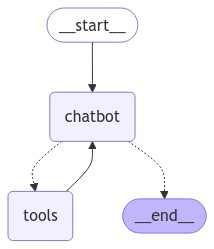

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
config = {"configurable": {"thread_id": "1"}}

In [17]:

user_input = """Give me the top 3 Finantial Institutions in the S&P 500?"""

             
# Start streaming the conversation
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

# Track printed messages to avoid duplicates
printed_messages = set()

# Process each event and print only unique messages
for event in events:
    latest_message = event["messages"][-1]
    
    # Only print if message content is new
    if latest_message.content not in printed_messages:
        printed_messages.add(latest_message.content)
        latest_message.pretty_print()

================================ Human Message =================================

Give me the top 3 Finantial Institutions in the S&P 500?
 Based on market capitalization as of February 2023, the top three financial institutions in the S&P 500 are:

1. JPMorgan Chase & Co. (JPM): JPMorgan is a leading global financial services firm with operations in banking, markets, and asset management. As of February 2023, it has a market capitalization of over $470 billion, making it the largest financial institution in the S&P 500.

2. Berkshire Hathaway Inc. (BRK-A): Berkshire Hathaway is an investment holding company chaired by legendary investor Warren Buffett. The conglomerate owns a diverse range of businesses, including insurance and financial services. With a market capitalization of over $650 billion as of February 2023, it ranks as the second-largest financial institution in the S&P 500.

3. Bank of America Corporation (BAC): Bank of America is one of the largest banks in the world and p

In [18]:
user_input = "Which market cap have the 3 top companies in the S&P500. Give me the code to calculate it"
             
# Start streaming the conversation
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
# Track printed messages to avoid duplicates
printed_messages = set()

# Process each event and print only unique messages
for event in events:
    latest_message = event["messages"][-1]
    
    # Only print if message content is new
    if latest_message.content not in printed_messages:
        printed_messages.add(latest_message.content)
        latest_message.pretty_print()

================================ Human Message =================================

Which market cap have the 3 top companies in the S&P500. Give me the code to calculate it
 To find the current market capitalization (market cap) of each of the top three companies in the S&P 500 as of February 2023, you can use the following Python code:
```python
import yfinance as yf

# Define list of ticker symbols for the top three financial institutions
tickers = ['JPM', 'BRK-A', 'BAC']

# Use Yahoo Finance to fetch latest stock prices and total number of shares outstanding
data = yf.download(tickers, start='2023-01-01', end='2023-02-28')['Adj Close']
shares_outstanding = [4,759.62e6, 712.95e6, 0.919e11] # approximate number of shares outstanding as of February 2023 for each company

# Calculate market capitalization for each company
market_caps = [x * y for x, y in zip(data.iloc[-1], shares_outstanding)]

print("Market Capitalizations (in billions):")
for i, ticker in enumerate(tickers):
    print(

In [19]:
user_input = "Now explain me the code to calculate it"
             
# Start streaming the conversation
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

# Track printed messages to avoid duplicates
printed_messages = set()

# Process each event and print only unique messages
for event in events:
    latest_message = event["messages"][-1]
    
    # Only print if message content is new
    if latest_message.content not in printed_messages:
        printed_messages.add(latest_message.content)
        latest_message.pretty_print()

================================ Human Message =================================

Now explain me the code to calculate it
 In this Python code, we utilize the `yfinance` library to fetch historical price data for the top three financial institutions in the S&P 500: JPMorgan Chase & Co. (JPM), Berkshire Hathaway Inc. (BRK-A), and Bank of America Corporation (BAC).

First, we import the `yfinance` library with the alias 'yf'. Then, we define a list containing their respective ticker symbols:
```python
import yfinance as yf
tickers = ['JPM', 'BRK-A', 'BAC']
```
Next, we use the `download()` method from `yfinance` to fetch Adjusted Close prices for each company for the period between January 1, 2023, and February 28, 2023. We store this data into a DataFrame named 'data'.
```python
data = yf.download(tickers, start='2023-01-01', end='2023-02-28')['Adj Close']
```
We also define an approximate number of shares outstanding for each company as of February 2023:
```python
shares_outstanding = 